# Data loading Part

## Mount google-drive & Load dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#shared path to drive
SHARED_PATH="/content/drive/MyDrive/Classroom/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours"

#direct path to drive
DIRECT_PATH="/content/drive/MyDrive/Classroom/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours"

Mounted at /content/drive


In [ ]:
import os

# Determine the data path based on the existence of shared or direct paths
root_path = SHARED_PATH if os.path.exists(SHARED_PATH) else DIRECT_PATH if os.path.exists(DIRECT_PATH) else None

data_path = ''
# Print the chosen path or an error message
if root_path:
    print(f"Using path: {root_path}")
    data_path = root_path + "/CNC_BuildingClassify_expr1_filtered_data"
    for filename in os.listdir(data_path):
        print(filename)
else:
    print("Neither shared nor direct path exists. Please check the paths.")


Using path: /content/drive/MyDrive/Classroom/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours
Training_data
Untitled
Validate_data
Testing_data_mix
test_individually_expr1.ipynb
resnet18_image_classifier_full_81.pth
old
resnet18_image_classifier_full.pth
training_expr1.ipynb


## Specify training and testing data path

In [ ]:
path_train_data= data_path + "/Training_data"
path_test_data= data_path + "/Validate_data"

## Importing pytorch and setup CPU or GPU

In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define device (CPU or GPU)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


## Define data transformations

In [ ]:
import torchvision.transforms as transforms

mean=[0.485, 0.456, 0.406]
standev=[0.229, 0.224, 0.225]
px=224

train_transform = transforms.Compose([
    transforms.Resize((px, px)),
    # transforms.RandomRotation(10),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(mean), std=(standev))
])

test_transform =  transforms.Compose([
    transforms.Resize((px, px)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(mean), std=(standev))
])

print(train_transform)

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


## Load dataset with Torch

In [ ]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

train_dataset = ImageFolder(root=path_train_data, transform=train_transform)
test_dataset = ImageFolder(root=path_test_data, transform=test_transform)

print(train_dataset)
print(f'data classes are: {train_dataset.classes}')
print(test_dataset)
print(f'data classes are: {test_dataset.classes}')

Dataset ImageFolder
    Number of datapoints: 78
    Root location: /content/drive/MyDrive/Classroom/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours/CNC_BuildingClassify_expr1_filtered_data/Training_data
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
data classes are: ['admin', 'chemistry', 'gurudeb', 'heritage']
Dataset ImageFolder
    Number of datapoints: 16
    Root location: /content/drive/MyDrive/Classroom/ChandernagoreCollegeSemVI-Addon 2025 Sem VI Computer Science Honours/CNC_BuildingClassify_expr1_filtered_data/Validate_data
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.22

### Visualization of transformation

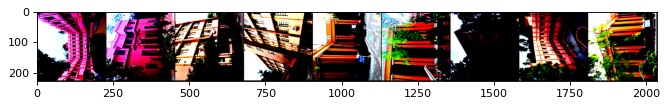

labels: tensor([2, 1, 0, 0, 3, 3, 0, 2, 3])


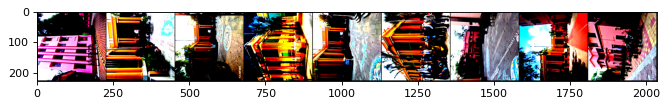

labels: tensor([2, 3, 3, 3, 3, 3, 1, 3, 1])


In [ ]:
def disp_img_grid(dataset):
    loader = DataLoader(dataset, batch_size=9, shuffle=True)
    batch = next(iter(loader))
    img, lbl = batch

    grid = torchvision.utils.make_grid(img, nrow=1)
    plt.figure(figsize=(10, 10),dpi=80)
    # Use permute instead of calling the tensor
    plt.imshow(np.transpose(grid.permute(1, 2, 0).numpy(), (1, 0, 2)))
    # plt.axis('off')  # Hide axes
    plt.show()  # Show the plot
    print(f'labels: {lbl}')

disp_img_grid(train_dataset)
disp_img_grid(test_dataset)

## Data loader

In [ ]:
BATCH_SIZE = 1
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

print(train_loader)
print(test_loader)

# CNN Defining and Training part

## Use Readymade CNN Model(ResNet) and modify it

In [ ]:
# Load torch's ResNet18 model
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

# rsnt18_model = models.resnet18(weights ='ResNet18_Weights.DEFAULT')  # pretrained = True/false
rsnt18_model = models.resnet18(weights = None) # pretrained = False)

### We have to modify the last layer

In [ ]:
# modifying the last layer
last_layer_in = rsnt18_model.fc.in_features
no_of_classes = len(train_dataset.classes)
print(f"last layer output for model = {last_layer_in} -> convert to {no_of_classes} output")
rsnt18_model.fc = nn.Linear(last_layer_in, no_of_classes)

last layer output for model = 512 -> convert to 4 output


### send the model to GPU/CPU

In [ ]:
# Move model to device
rsnt18_model = rsnt18_model.to(DEVICE)
print(rsnt18_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### define loss function

In [ ]:
loss_fn = nn.CrossEntropyLoss() # criterion = torch.nn.CrossEntropyLoss()
print(loss_fn)

CrossEntropyLoss()


### Define optimaizer

In [ ]:
optimizer = optim.Adam(rsnt18_model.parameters(), lr=0.001) # lr = learning rate
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


## Defining functions for train and validation

### function for training

In [ ]:
from tqdm import tqdm

def train_NN(model, train_loader, test_loader, loss_function, optim, n_epochs=10):
    for epoch in tqdm(range(n_epochs)):
        model.train()  # Set the model to training mode
        training_loss = [] # list to store the training loss for each batch

        for i_image, i_label in train_loader:
            i_image = i_image.to(DEVICE)
            i_label = i_label.to(DEVICE)

            optimizer.zero_grad() # Zero out the gradients to prevent accumulation
            output = model(i_image) # Get the model's output for the current batch of imgs
            loss = loss_function(output, i_label) # Calculate the loss using the defined loss function
            loss.backward()  # Perform backpropagation to compute gradients
            optimizer.step()  # Update the model's weights using the optimizer

            training_loss.append(loss.item())

        print("Training loss at", epoch, "iteration is", np.mean(training_loss))
        # eval_model_on_test(model,test_loader)
    print("Training done.....................")

### Function for validation test

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def eval_model_on_test(model, test_loader, display_labels):
    model.eval()  # Set the model to evaluation mode
    pred_correctly = 0
    total = 0
    actual_labels = []
    predicted_labels = []

    with torch.no_grad():
        for i_image, i_label in test_loader:
            i_image = i_image.to(DEVICE)
            i_label = i_label.to(DEVICE)

            total += i_label.size(0) # number of samples in the current batch
            output = model(i_image)

            # get predicted class index (max probability) for each image in the batch
            _, predicted = torch.max(output.data, 1) # its indx along (dimension 1,which corresponds to the class scores).
            pred_correctly += (predicted == i_label).sum().item() # total count of correctly predicted samples.

            # Collect actual_labels & pridected_labels for confusion matrix
            actual_labels.extend(i_label.cpu().numpy()) # tensor -> NP array and extending the list.
            predicted_labels.extend(predicted.cpu().numpy())

    accuracy = 100.0 * pred_correctly / total
    print(f'--Testing... got {pred_correctly} out of {total} correctly accuracy=({accuracy:.2f}%)')

    # Generate and display confusion matrix
    ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix(actual_labels, predicted_labels),
        display_labels=display_labels
    ).plot()
    plt.xticks(rotation=90)
    plt.show()
    return accuracy


## Doing train

In [ ]:
train_NN(rsnt18_model, train_loader, test_loader, loss_fn, optimizer, n_epochs=20)

  5%|▌         | 1/20 [00:47<15:10, 47.93s/it]

Training loss at 0 iteration is 1.5010923260870652


 10%|█         | 2/20 [00:54<07:01, 23.43s/it]

Training loss at 1 iteration is 0.8426403125318197


 15%|█▌        | 3/20 [01:00<04:27, 15.74s/it]

Training loss at 2 iteration is 0.6735311777641376


 20%|██        | 4/20 [01:07<03:12, 12.01s/it]

Training loss at 3 iteration is 0.34557239373381704


 25%|██▌       | 5/20 [01:13<02:31, 10.09s/it]

Training loss at 4 iteration is 0.1367981351720981


 30%|███       | 6/20 [01:19<02:02,  8.74s/it]

Training loss at 5 iteration is 0.14038739699082306


 35%|███▌      | 7/20 [01:26<01:44,  8.07s/it]

Training loss at 6 iteration is 0.3576718582294117


 40%|████      | 8/20 [01:32<01:29,  7.43s/it]

Training loss at 7 iteration is 0.09013613893722112


 45%|████▌     | 9/20 [01:39<01:19,  7.21s/it]

Training loss at 8 iteration is 0.0211890180183288


 50%|█████     | 10/20 [01:45<01:08,  6.80s/it]

Training loss at 9 iteration is 0.013407111376858292


 55%|█████▌    | 11/20 [01:52<01:01,  6.84s/it]

Training loss at 10 iteration is 0.009388166293203354


 60%|██████    | 12/20 [01:58<00:52,  6.58s/it]

Training loss at 11 iteration is 0.007345899655961265


 65%|██████▌   | 13/20 [02:05<00:46,  6.68s/it]

Training loss at 12 iteration is 0.005988299446658065


 70%|███████   | 14/20 [02:11<00:38,  6.47s/it]

Training loss at 13 iteration is 0.0049912613780739214


 75%|███████▌  | 15/20 [02:18<00:33,  6.62s/it]

Training loss at 14 iteration is 0.0042463601275812835


 80%|████████  | 16/20 [02:24<00:25,  6.46s/it]

Training loss at 15 iteration is 0.003628213600351069


 85%|████████▌ | 17/20 [02:31<00:19,  6.63s/it]

Training loss at 16 iteration is 0.003156706540045352


 90%|█████████ | 18/20 [02:37<00:12,  6.43s/it]

Training loss at 17 iteration is 0.0027638771668231734


 95%|█████████▌| 19/20 [02:44<00:06,  6.57s/it]

Training loss at 18 iteration is 0.002455199326131827


100%|██████████| 20/20 [02:50<00:00,  8.50s/it]

Training loss at 19 iteration is 0.0021834024601281644
Training done.....................


## Validate the model

--Testing... got 14 out of 16 correctly accuracy=(87.50%)


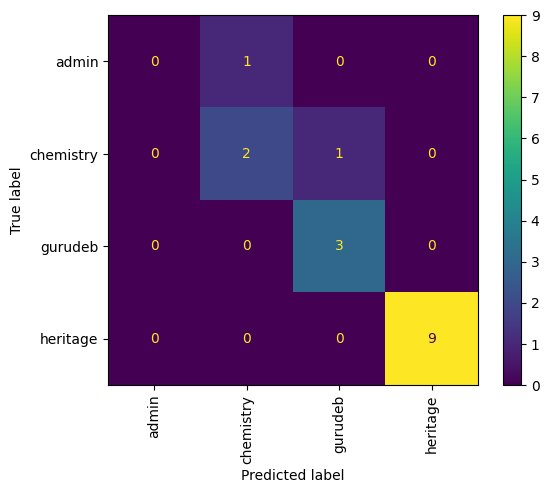

87.5

In [ ]:
eval_model_on_test(rsnt18_model, test_loader, test_dataset.classes)

## Save trained model

In [ ]:
# print(rsnt18_model.state_dict())
# torch.save(rsnt18_model.state_dict(), data_path +'/resnet18_image_classifier.pth')

#save entire model
torch.save(rsnt18_model, data_path +'/resnet18_image_classifier_full.pth')

os.listdir(data_path)

['Training_data',
 'Untitled',
 'Validate_data',
 'Testing_data_mix',
 'test_individually_expr1.ipynb',
 'resnet18_image_classifier_full_81.pth',
 'old',
 'resnet18_image_classifier_full.pth',
 'training_expr1.ipynb']

# Individual testing

## Predefined parameters

In [ ]:
# MODEL = data_path+"/resnet18_image_classifier_full.pth"
MODEL = rsnt18_model
TRANSFORM = test_transform
CATEGORIES = test_dataset.classes

## Function for individual image classification

In [ ]:
from PIL import Image

def classify_this_image(img_path, model=MODEL,img_transform=TRANSFORM,classes=CATEGORIES):
    model.eval() # set model to evaluation/testing mode
    input_img = Image.open(data_path + img_path)

    plt.figure(figsize=(10, 10),dpi=30)
    plt.imshow(input_img) # display the loaded image
    plt.axis('off')
    plt.show()

    img_tensor = img_transform(input_img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        output = model(img_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        print(probabilities)
        _, predicted_class_index = torch.max(probabilities, 1)
        predicted_class = classes[predicted_class_index.item()]
        print(f"Predicted class: {predicted_class}")

## Input image and Classify

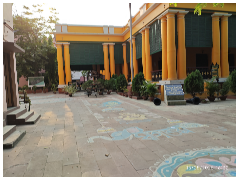

tensor([[0.0030, 0.0031, 0.0098, 0.9841]], device='cuda:0')
Predicted class: heritage


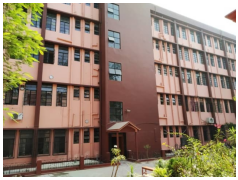

tensor([[0.9853, 0.0013, 0.0084, 0.0049]], device='cuda:0')
Predicted class: admin


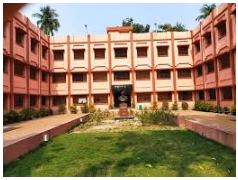

tensor([[0.0145, 0.0355, 0.9058, 0.0442]], device='cuda:0')
Predicted class: gurudeb


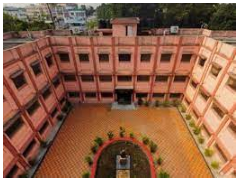

tensor([[0.0206, 0.1420, 0.7992, 0.0382]], device='cuda:0')
Predicted class: gurudeb


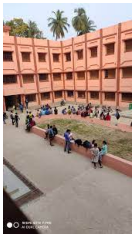

tensor([[0.0793, 0.1465, 0.5433, 0.2309]], device='cuda:0')
Predicted class: gurudeb


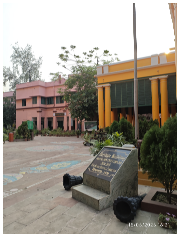

tensor([[0.1585, 0.1254, 0.1819, 0.5342]], device='cuda:0')
Predicted class: heritage


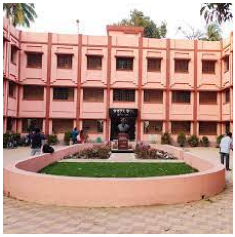

tensor([[0.1232, 0.0681, 0.5657, 0.2431]], device='cuda:0')
Predicted class: gurudeb


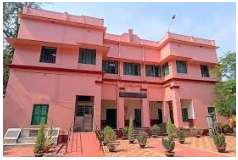

tensor([[0.0116, 0.9694, 0.0131, 0.0059]], device='cuda:0')
Predicted class: chemistry


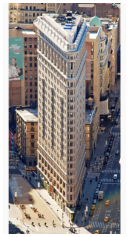

tensor([[0.2867, 0.1684, 0.2669, 0.2780]], device='cuda:0')
Predicted class: admin


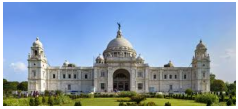

tensor([[0.0946, 0.2134, 0.3302, 0.3617]], device='cuda:0')
Predicted class: heritage


In [ ]:
classify_this_image("/Testing_data_mix/Heritage_test/fview_0001.jpg")
classify_this_image("/Testing_data_mix/Admin_test/campus-admin-building.jpg")
classify_this_image("/Testing_data_mix/Gurudeb_test/images (2).jpeg")
classify_this_image("/Testing_data_mix/Gurudeb_test/images (3).jpeg")
classify_this_image("/Testing_data_mix/Gurudeb_test/images (4).jpeg")
classify_this_image("/Testing_data_mix/Heritage_test/Copy of diagonal_0002.jpg")
classify_this_image("/Testing_data_mix/Gurudeb_test/images (5).jpeg")
classify_this_image("/Testing_data_mix/Chemistry_test/images (8).jpeg")
classify_this_image("/Testing_data_mix/Unknown_test/flatiron.jpeg")
classify_this_image("/Testing_data_mix/Unknown_test/victoria.jpeg")

In [ ]:
# GradCAM